# Interactive ROI Visualization
Explore FG+OTS ROI overlays with adjustable slice viewing

In [8]:
import numpy as np
data = np.load('/user_data/csimmon2/long_pt/analyses/fgots_extraction/sub-004_ses01_face_word_FGOTS.npy')
print(f"T-stat range: {data[:,3].min():.2f} to {data[:,3].max():.2f}")

T-stat range: -3.43 to 6.46


Face-selective (t>2): 4395 voxels
Word-selective (t<-2): 111 voxels
Range: -3.43 to 6.46
Mean: 2.11


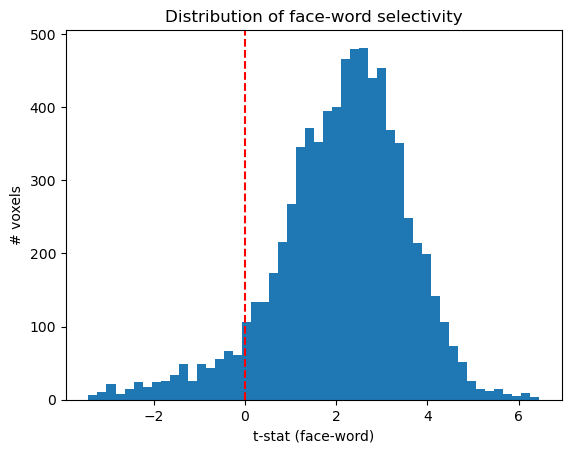

In [9]:
# What's your distribution of t-stats?
import numpy as np
data = np.load('/user_data/csimmon2/long_pt/analyses/fgots_extraction/sub-004_ses01_face_word_FGOTS.npy')
t_stats = data[:, 3]

print(f"Face-selective (t>2): {np.sum(t_stats > 2)} voxels")
print(f"Word-selective (t<-2): {np.sum(t_stats < -2)} voxels")
print(f"Range: {t_stats.min():.2f} to {t_stats.max():.2f}")
print(f"Mean: {t_stats.mean():.2f}")

# Histogram
import matplotlib.pyplot as plt
plt.hist(t_stats, bins=50)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('t-stat (face-word)')
plt.ylabel('# voxels')
plt.title('Distribution of face-word selectivity')
plt.show()

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
base_dir = '/user_data/csimmon2/long_pt'

subjects_info = {
    'sub-004': {'hemi': 'l', 'name': 'UD (left resection)'},
    'sub-007': {'hemi': 'r', 'name': 'TC (right resection)'},
    'sub-021': {'hemi': 'r', 'name': 'OT (right resection)'}
}

In [3]:
def load_data(subject):
    """Load anatomical and ROI data"""
    hemi = subjects_info[subject]['hemi']
    
    anat_file = f'{base_dir}/{subject}/ses-01/anat/{subject}_ses-01_T1w_brain.nii.gz'
    roi_file = f'{base_dir}/{subject}/ses-01/ROIs/{hemi}_VOTC_FG_OTS_mask.nii.gz'
    
    anat = nib.load(anat_file).get_fdata()
    roi = nib.load(roi_file).get_fdata()
    
    return anat, roi

In [4]:
def plot_slice(subject, view='axial', slice_idx=None):
    """Plot a single slice with ROI overlay"""
    anat, roi = load_data(subject)
    
    # Get ROI extent
    roi_coords = np.where(roi > 0)
    n_vox = len(roi_coords[0])
    
    if view == 'axial':
        if slice_idx is None:
            slice_idx = int(np.mean(roi_coords[2]))
        img = np.rot90(anat[:, :, slice_idx])
        roi_slice = np.rot90(roi[:, :, slice_idx])
        title = f'Axial (Z={slice_idx})'
        
    elif view == 'coronal':
        if slice_idx is None:
            slice_idx = int(np.mean(roi_coords[1]))
        img = np.rot90(anat[:, slice_idx, :])
        roi_slice = np.rot90(roi[:, slice_idx, :])
        title = f'Coronal (Y={slice_idx})'
        
    elif view == 'sagittal':
        if slice_idx is None:
            slice_idx = int(np.mean(roi_coords[0]))
        img = np.rot90(anat[slice_idx, :, :])
        roi_slice = np.rot90(roi[slice_idx, :, :])
        title = f'Sagittal (X={slice_idx})'
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray', vmin=0, vmax=np.percentile(anat, 99))
    ax.imshow(roi_slice, cmap='Reds', alpha=0.6 * (roi_slice > 0))
    ax.set_title(f"{subjects_info[subject]['name']} - {title}\nROI: {n_vox} voxels", 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## Interactive Slice Viewer
Use sliders to navigate through slices

In [ ]:
# Select subject
SUBJECT = 'sub-004'  # Change to 'sub-007' or 'sub-021'

anat, roi = load_data(SUBJECT)
roi_coords = np.where(roi > 0)

# Get ROI bounds
x_min, x_max = roi_coords[0].min(), roi_coords[0].max()
y_min, y_max = roi_coords[1].min(), roi_coords[1].max()
z_min, z_max = roi_coords[2].min(), roi_coords[2].max()

print(f"ROI extent:")
print(f"  X: {x_min} to {x_max} (sagittal slices)")
print(f"  Y: {y_min} to {y_max} (coronal slices)")
print(f"  Z: {z_min} to {z_max} (axial slices)")

In [ ]:
# Axial view (through Z)
interact(lambda z: plot_slice(SUBJECT, 'axial', z),
         z=IntSlider(min=z_min-10, max=z_max+10, step=1, value=int(np.mean(roi_coords[2])),
                    description='Z slice'))

In [ ]:
# Coronal view (through Y)
interact(lambda y: plot_slice(SUBJECT, 'coronal', y),
         y=IntSlider(min=y_min-10, max=y_max+10, step=1, value=int(np.mean(roi_coords[1])),
                    description='Y slice'))

In [ ]:
# Sagittal view (through X)
interact(lambda x: plot_slice(SUBJECT, 'sagittal', x),
         x=IntSlider(min=x_min-10, max=x_max+10, step=1, value=int(np.mean(roi_coords[0])),
                    description='X slice'))

## Multi-subject Comparison

FileNotFoundError: No such file or no access: '/user_data/csimmon2/long_pt/sub-007/ses-01/ROIs/r_VOTC_FG_OTS_mask.nii.gz'

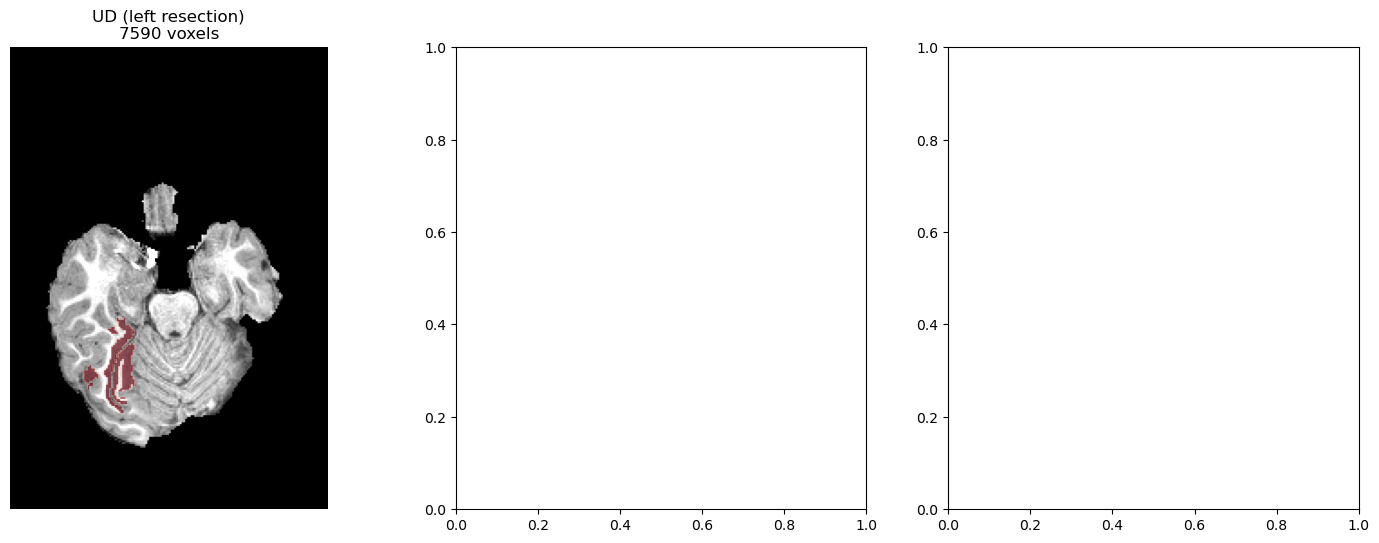

In [5]:
def compare_subjects_slice(view='axial'):
    """Compare ROI across all subjects at ROI center"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, subject in enumerate(['sub-004', 'sub-007', 'sub-021']):
        anat, roi = load_data(subject)
        roi_coords = np.where(roi > 0)
        n_vox = len(roi_coords[0])
        
        if view == 'axial':
            slice_idx = int(np.mean(roi_coords[2]))
            img = np.rot90(anat[:, :, slice_idx])
            roi_slice = np.rot90(roi[:, :, slice_idx])
        elif view == 'coronal':
            slice_idx = int(np.mean(roi_coords[1]))
            img = np.rot90(anat[:, slice_idx, :])
            roi_slice = np.rot90(roi[:, slice_idx, :])
        elif view == 'sagittal':
            slice_idx = int(np.mean(roi_coords[0]))
            img = np.rot90(anat[slice_idx, :, :])
            roi_slice = np.rot90(roi[slice_idx, :, :])
        
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=np.percentile(anat, 99))
        axes[i].imshow(roi_slice, cmap='Reds', alpha=0.6 * (roi_slice > 0))
        axes[i].set_title(f"{subjects_info[subject]['name']}\n{n_vox} voxels", fontsize=12)
        axes[i].axis('off')
    
    plt.suptitle(f'{view.capitalize()} view at ROI center', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show all three views
compare_subjects_slice('axial')
compare_subjects_slice('coronal')
compare_subjects_slice('sagittal')

## ROI Statistics

In [6]:
for subject in ['sub-004', 'sub-007', 'sub-021']:
    anat, roi = load_data(subject)
    roi_coords = np.where(roi > 0)
    
    print(f"\n{subjects_info[subject]['name']} ({subject}):")
    print(f"  Total voxels: {len(roi_coords[0])}")
    print(f"  X extent: {roi_coords[0].min()}-{roi_coords[0].max()} (span: {roi_coords[0].max()-roi_coords[0].min()})")
    print(f"  Y extent: {roi_coords[1].min()}-{roi_coords[1].max()} (span: {roi_coords[1].max()-roi_coords[1].min()})")
    print(f"  Z extent: {roi_coords[2].min()}-{roi_coords[2].max()} (span: {roi_coords[2].max()-roi_coords[2].min()})")
    print(f"  Center: ({int(np.mean(roi_coords[0]))}, {int(np.mean(roi_coords[1]))}, {int(np.mean(roi_coords[2]))})")


UD (left resection) (sub-004):
  Total voxels: 7590
  X extent: 35-69 (span: 34)
  Y extent: 51-110 (span: 59)
  Z extent: 116-151 (span: 35)
  Center: (54, 78, 127)


FileNotFoundError: No such file or no access: '/user_data/csimmon2/long_pt/sub-007/ses-01/ROIs/r_VOTC_FG_OTS_mask.nii.gz'